In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgbm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
train_features = pd.read_csv("data/training_set_features.csv", index_col="respondent_id")
train_labels = pd.read_csv("data/training_set_labels.csv", index_col="respondent_id")
test_features = pd.read_csv("data/test_set_features.csv", index_col="respondent_id")
submission = pd.read_csv("data/submission_format.csv", index_col="respondent_id")
df = train_features.join(train_labels)

### Preparing the data

In [3]:
# Measure of association between h1n1 and seasonal vaccines
train_labels["h1n1_vaccine"].corr(train_labels["seasonal_vaccine"], method="pearson")

0.37714265306144684

#### Feature Engineering

In [4]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
       ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [5]:
preprocessor = ColumnTransformer([
    ("num", num_transformer, selector(dtype_exclude="object")),
    ("cat", cat_transformer, selector(dtype_include="object")),
])

In [6]:
train_features_prepared = preprocessor.fit_transform(train_features)

#### Training

In [7]:
log_reg = MultiOutputClassifier(estimator=LogisticRegression(penalty="l2", C=1, solver='lbfgs', max_iter=1000))
svm_clf = MultiOutputClassifier(estimator=SVC(kernel="rbf", probability=True))
rnd_clf = MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10))

In [8]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train_features_prepared,
    train_labels,
    test_size=0.2,
    shuffle=True,
    stratify=train_labels,
    random_state=6
)

In [66]:
for clf in (log_reg, svm_clf, rnd_clf):
    clf.fit(train_features_prepared, train_labels)
    y_pred = clf.predict(X_eval)
    print(clf.__class__.__name__, accuracy_score(y_eval, y_pred))

MultiOutputClassifier 0.6770872332459753
MultiOutputClassifier 0.7388618494945713
MultiOutputClassifier 1.0


In [9]:
svm_clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=SVC(probability=True))

#### Evaluation

In [10]:
preds = svm_clf.predict_proba(X_eval)

In [11]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)

In [12]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color="grey", linestyle="--")
    ax.set_ylabel("TPR")
    ax.set_xlabel("FPR")
    ax.set_title(f"{label_name}: \n AUC = {roc_auc_score(y_true, y_score):.4f}")

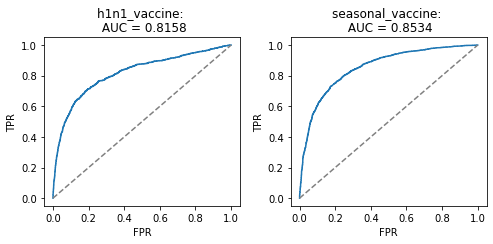

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval["h1n1_vaccine"], y_preds["h1n1_vaccine"], "h1n1_vaccine", ax=ax[0])
plot_roc(y_eval["seasonal_vaccine"], y_preds["seasonal_vaccine"], "seasonal_vaccine", ax=ax[1])

fig.tight_layout()

In [14]:
roc_auc_score(y_eval, y_preds)

0.8345752978403173

### Prediction

In [16]:
svm_clf.fit(train_features_prepared, train_labels)

MultiOutputClassifier(estimator=SVC(probability=True))

In [17]:
test_probas = svm_clf.predict_proba(test_features)

C:\Users\saaye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: '35 - 44 Years'

In [ ]:
np.testing.assert_array_equal(test_features.index.values, submission.index.values)
submission["h1n1_vaccine"] = test_probas[0][:, 1]
submission["seasonal_vaccine"] = test_probas[1][:, 1]
submission.to_csv("prediction/submission.csv", index=True)